In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import pandas as pd
def read_jsonl(file):
    with open(file, 'r') as f:
        data=[json.loads(line) for line in f]
        print(f'Length of data is {len(data)}')
        return data
def filter_and_replace(value):
    value=value.lower()
    if 'yes' in value:
        return 'yes'
    elif 'no' in value:
        return 'no'
    else:
        return value

def entropy(p_yes, p_no):
    """Calculate the entropy for a given probability."""
    if p_yes <= 0 or p_no <= 0:
        return 0
    p_yes = torch.tensor([p_yes], dtype=torch.float32)
    p_no = torch.tensor([p_no], dtype=torch.float32)
    entropy_value = -p_yes * torch.log2(p_yes) - p_no * torch.log2(p_no)
    return entropy_value.item()




## 读取数据

In [4]:
# obj_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Object/Minigpt4/Object.jsonl')
obj_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Object/llava-v1.5/llava-v1.5-7b/Object.jsonl')
#
#
obj_pd=pd.DataFrame(obj_data)

# rel_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Relation/Minigpt4/Relation.jsonl')
rel_data=read_jsonl('/home/ubuntu/hallu_team/junkai/Dataset/RLC-bench/answer/Relation/llava-v1.5/llava-v1.5-7b/Relation.jsonl')
rel_pd=pd.DataFrame(rel_data)

Length of data is 9000
Length of data is 9740


## 处理Object (POPE)数据

In [5]:
obj_pd['entropy'] = obj_pd.apply(lambda row: entropy(row['yes_prob'], row['no_prob']), axis=1)
obj_pd['decision_prob']= obj_pd[['yes_prob', 'no_prob']].max(axis=1)
obj_pd['response']=obj_pd['response'].apply(filter_and_replace)

obj_wrong=obj_pd[obj_pd['response']!=obj_pd['label']]
obj_right=obj_pd[obj_pd['response']==obj_pd['label']]
print(f'Length of wrong object case is {len(obj_wrong)}')
print(f'Length of right object case is {len(obj_right)}')
equal_obj_right = obj_right.sample(n=len(obj_wrong), random_state=1)

print(f'Length of equal object right is {len(equal_obj_right)}')
print(f'Length of total is {len(obj_pd)}')

obj_pd.head()

Length of wrong object case is 1333
Length of right object case is 7667
Length of equal object right is 1333
Length of total is 9000


,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,entropy,decision_prob
0,COCO_val2014_000000310196,Is there a snowboard in the image?,yes,yes,llava-v1.5-7b,object-YesNo,0.538983,0.461017,0.995611,0.538983
1,COCO_val2014_000000310196,Is there a backpack in the image?,no,no,llava-v1.5-7b,object-YesNo,0.320821,0.679179,0.905272,0.679179
2,COCO_val2014_000000310196,Is there a person in the image?,yes,yes,llava-v1.5-7b,object-YesNo,0.997527,0.002473,0.024975,0.997527
3,COCO_val2014_000000310196,Is there a car in the image?,no,no,llava-v1.5-7b,object-YesNo,0.024798,0.975202,0.167593,0.975202
4,COCO_val2014_000000310196,Is there a skis in the image?,yes,yes,llava-v1.5-7b,object-YesNo,0.857768,0.142232,0.590054,0.857768


## Object幻觉 对错case的概率分布

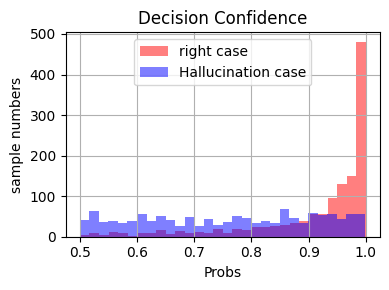

In [11]:
plt.figure(figsize=(4, 3))


plt.hist(equal_obj_right['decision_prob'], bins=30, alpha=0.5, label='right case', color='red')
plt.hist(obj_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='blue')



plt.xlabel('Probs')
plt.ylabel('sample numbers')
plt.title('Decision Confidence')

plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 最终放在论文中的img 双图

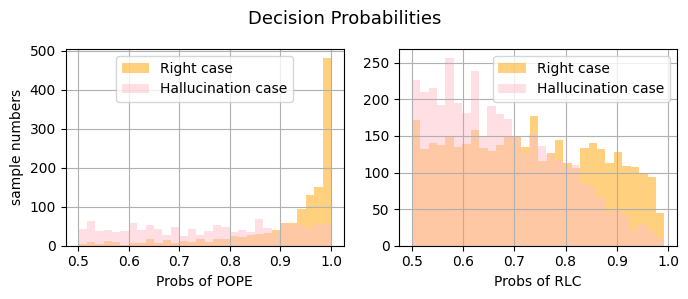

In [37]:
import matplotlib.pyplot as plt

# 创建一个2行1列的子图
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

fig.suptitle('Decision Probabilities', fontsize=13)
# 第一张图
axs[0].hist(equal_obj_right['decision_prob'], bins=30, alpha=0.5, label='Right case', color='orange')
axs[0].hist(obj_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='pink')
axs[0].set_xlabel('Probs of POPE')
axs[0].set_ylabel('sample numbers')
# axs[0].set_title('Decision Confidence')
axs[0].legend(loc='upper center')
axs[0].grid(True)

# 第二张图
axs[1].hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='Right case', color='orange')
axs[1].hist(rel_wrong['decision_prob'], bins=30, alpha=0.5, label='Hallucination case', color='pink')
axs[1].set_xlabel('Probs of RLC')
# axs[1].set_ylabel('sample numbers')
# axs[1].set_title('Probs of Right and Wrong Rel Hallucination')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2)#top 参数调整总标题距离图形的距离，值越小，距离越近  wspace 参数调整两个子图之间的水平间距
# 保存图像
plt.savefig('combined_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Object 物体幻觉对错的case的熵的分布

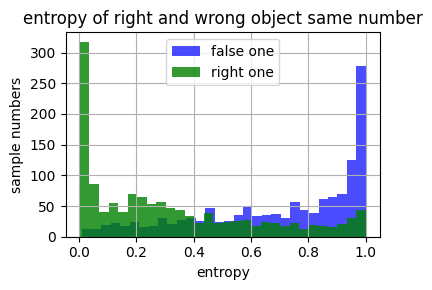

In [7]:
plt.figure(figsize=(4, 3))
plt.hist(obj_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
plt.hist(equal_obj_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('entropy of right and wrong object same number')
plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Object绘制折线图

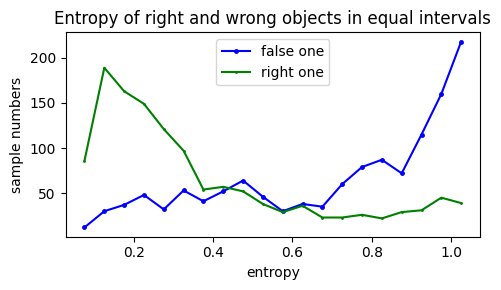

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 自动计算 entropy 属性的范围
min_entropy = min(obj_wrong['entropy'].min(), equal_obj_right['entropy'].min())
max_entropy = max(obj_wrong['entropy'].max(), equal_obj_right['entropy'].max())

# 定义区间，步长为 0.05
bins = np.arange(min_entropy, max_entropy + 0.05, 0.05)
labels = bins[:-1] + 0.05
# 计算每个区间内的样本数量
obj_wrong_binned = pd.cut(obj_wrong['entropy'], bins=bins,labels=labels,include_lowest=True).value_counts().sort_index()
equal_obj_right_binned = pd.cut(equal_obj_right['entropy'], bins=bins,labels=labels,include_lowest=True).value_counts().sort_index()

# 绘制折线图
plt.figure(figsize=(5, 3))
plt.plot(obj_wrong_binned.index, obj_wrong_binned.values, marker='.', markersize=5, label='false one', color='blue')
plt.plot(equal_obj_right_binned.index, equal_obj_right_binned.values, marker='.', markersize=2,label='right one', color='green')

plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('Entropy of right and wrong objects in equal intervals')
plt.legend(loc='upper center')
# plt.grid(True)
plt.tight_layout()
plt.savefig('test1.pdf', dpi=300, bbox_inches='tight')
plt.show()

## object绘制plotly图

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio



# 自动计算 entropy 属性的范围
min_entropy = min(obj_wrong['entropy'].min(), equal_obj_right['entropy'].min())
max_entropy = max(obj_wrong['entropy'].max(), equal_obj_right['entropy'].max())

# 定义区间，步长为 0.05
bins = np.arange(min_entropy, max_entropy + 0.05, 0.05)
labels = bins[:-1] + 0.05
# 计算每个区间内的样本数量
obj_wrong_binned = pd.cut(obj_wrong['entropy'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
equal_obj_right_binned = pd.cut(equal_obj_right['entropy'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

# 使用 Plotly 绘制折线图
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=obj_wrong_binned.index.astype(str),
    y=obj_wrong_binned.values,
    mode='lines+markers',
    name='false one',
    marker=dict(size=5),
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=equal_obj_right_binned.index.astype(str),
    y=equal_obj_right_binned.values,
    mode='lines+markers',
    name='right one',
    marker=dict(size=5),
    line=dict(color='green')
))

# 更新布局
fig.update_layout(
    title='Entropy of right and wrong objects in equal intervals',
    xaxis_title='entropy',
    yaxis_title='sample numbers',
    legend=dict(
        title='Legend',
        x=0.5,
        y=1,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2
    ),
    template='plotly_white',
    autosize=False,
    width=700,
    height=500,
    margin=dict(
        l=50,  # left margin
        r=50,  # right margin
        b=50,  # bottom margin
        t=50   # top margin
    )
)

# 保存为 PDF
# pio.write_image(fig, 'test1.pdf')

# 显示图表
# fig.show()

# 关系数据

## 处理关系数据

In [12]:
rel_pd['entropy'] = rel_pd.apply(lambda row: entropy(row['yes_prob'], row['no_prob']), axis=1)
rel_pd['decision_prob']= rel_pd[['yes_prob', 'no_prob']].max(axis=1)
rel_pd['response']=rel_pd['response'].apply(filter_and_replace)
rel_right=rel_pd[rel_pd['response']==rel_pd['label']]
rel_wrong=rel_pd[rel_pd['response']!=rel_pd['label']]
print(f'Length of wrong relation case is {len(rel_wrong)}')
print(f'关系的总case为 {len(rel_pd)}')
print(f'关系中 正确case的数量为 {len(rel_right)}')

equal_rel_right = rel_right.sample(n=len(rel_wrong), random_state=1)
print(f'Length of equal rel_right is {len(equal_rel_right)}')
rel_pd.head()

Length of wrong relation case is 3884
关系的总case为 9740
关系中 正确case的数量为 5856
Length of equal rel_right is 3884


,image_id,query_prompt,response,label,mllm_name,type,yes_prob,no_prob,yes_softmax_prob,no_softmax_prob,entropy,decision_prob
0,2384153,Is the sheep resting head in this photo? Pleas...,no,yes,"llava-v1.5-7b,",Yes/No,0.399712,0.600038,0.450085,0.549915,0.970958,0.600038
1,2384153,Is the sheep carrying head in this photo? plea...,no,no,"llava-v1.5-7b,",Yes/No,0.433868,0.565870,0.467047,0.532953,0.987507,0.565870
2,2315986,Is the man resting head in this photo? Please ...,yes,yes,"llava-v1.5-7b,",Yes/No,0.782574,0.217313,0.637669,0.362331,0.755354,0.782574
3,2315986,Is the man smoking head in this photo? please ...,no,no,"llava-v1.5-7b,",Yes/No,0.180068,0.819717,0.345326,0.654674,0.680474,0.819717
4,2351930,Is the orange resting stump in this photo? Ple...,yes,yes,"llava-v1.5-7b,",Yes/No,0.685791,0.313978,0.591897,0.408103,0.897920,0.685791


## 关系概率分布图

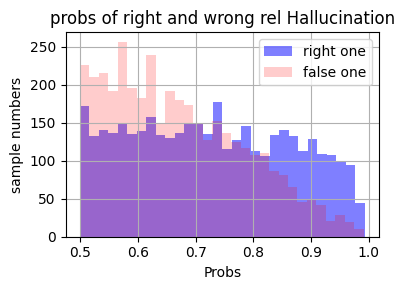

In [17]:
plt.figure(figsize=(4, 3))


plt.hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='right one', color='blue')
plt.hist(rel_wrong['decision_prob'], bins=30, alpha=0.2, label='false one', color='red')



plt.xlabel('Probs')
plt.ylabel('sample numbers')
plt.title('probs of right and wrong rel Hallucination')

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 关系幻觉熵分布图

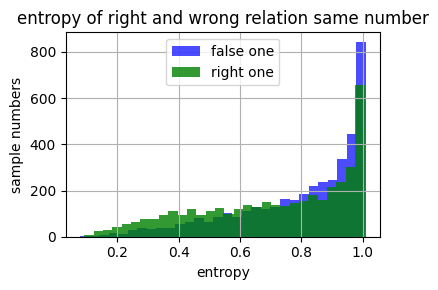

In [16]:
plt.figure(figsize=(4, 3))
plt.hist(rel_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
plt.hist(equal_rel_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
plt.xlabel('entropy')
plt.ylabel('sample numbers')
plt.title('entropy of right and wrong relation same number')
plt.legend(loc='upper center')
plt.grid(True)
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 关系两个图一起绘制

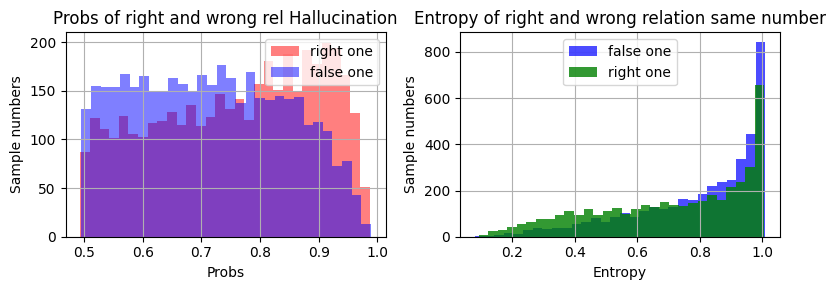

In [52]:
# 创建包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(8,3))

# 绘制第一个直方图
axes[0].hist(equal_rel_right['decision_prob'], bins=30, alpha=0.5, label='right one', color='red')
axes[0].hist(rel_wrong['decision_prob'], bins=30, alpha=0.5, label='false one', color='blue')
axes[0].set_xlabel('Probs')
axes[0].set_ylabel('Sample numbers')
axes[0].set_title('Probs of right and wrong rel Hallucination')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# 绘制第二个直方图
axes[1].hist(rel_wrong['entropy'], bins=30, alpha=0.7, label='false one', color='blue')
axes[1].hist(equal_rel_right['entropy'], bins=30, alpha=0.8, label='right one', color='green')
axes[1].set_xlabel('Entropy')
axes[1].set_ylabel('Sample numbers')
axes[1].set_title('Entropy of right and wrong relation same number')
axes[1].legend(loc='upper center')
axes[1].grid(True)

# 调整布局并保存图形
plt.tight_layout()
plt.savefig('test0.pdf', dpi=300, bbox_inches='tight')
plt.show()